# TS-DAR Tutorial for PP2A
**Reference**: Liu, B., Boysen, J.G., Unarta, I.C. et al. Exploring transition states of protein conformational changes via out-of-distribution detection in the hyperspherical latent space. Nat Commun 16, 349 (2025). https://doi.org/10.1038/s41467-024-55228-4

---
## TS-DAR Framework: An Overview

In this notebook, we introduce **Transition State identification via Dispersion and vAriational principle Regularized neural networks (TS-DAR)**, a computational framework that utilizes out-of-distribution (OOD) detection to accurately and simultaneously identify transition states involved in specific biomolecular conformational changes. TS-DAR leverages a deep learning model to map protein conformations from molecular dynamics (MD) simulations into a hyperspherical latent space. This low-dimensional representation preserves the essential kinetic information while still capturing the protein's dynamic behavior. To distinguish metastable states from transition states, TS-DAR employs a VAMP-2 loss and dispersion loss function:

1. **VAMP-2 Loss:** Encourages the latent representation to capture the slow dynamics of the system by maximizing correlations between time-lagged data.
2. **Dispersion Loss:** Ensures that the latent space does not collapse by promoting a well-dispersed representation of the macrostates.

---

## Before starting, make sure you have done the following:

#### 1. Download and install Anaconda:
wget https://repo.anaconda.com/archive/Anaconda3-2024.06-1-Linux-x86_64.sh <br>
./Anaconda3-2024.06-1-Linux-x86_64.sh
#### 2. Create a new conda environment and install the ts-dar source code locally:
conda create -n ts-dar python=3.9 <br>
conda activate ts-dar <br>
#### 3. Install dependencies
!pip install matplotlib numpy==1.26.1 scipy==1.11.4 torch==1.13.1 tqdm==4.66.1
#### 4. Clone the repository
!git clone https://github.com/xuhuihuang/ts-dar.git
#### 5. Install the package
!python -m pip install ./ts-dar

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from tsdart.utils import set_random_seed
from tsdart.loss import Prototypes
from tsdart.model import TSDART, TSDARTLayer, TSDARTEstimator
from tsdart.dataprocessing import Preprocessing

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda is available')
else:
    device = torch.device('cpu')
    print('cpu')

cpu


In [ ]:
def load_xvg(filename):
    with open(filename) as f:
        lines = [line for line in f if not line.startswith(('@', '#'))]
    data = np.genfromtxt(lines)
    return data

## Load the PP2A Data:

Please download the dataset from the link below, and place it under the base directory, unzip the file:

https://zenodo.org/records/16922765/files/PP2A.zip?download=1

Change the directrory to "./PP2A/".  



In [ ]:
data = []
for i in range(10):
    tmp = np.load(rf'./data/spec_osasis_filter_1000_select_CA_pairwise_distances_WT_{i}_traj.npy')
    print(np.shape(tmp))
    data.append(tmp)

phy_coord = []
for i in range(10):
    tmp = load_xvg(rf'./data/Carm_SLiM_dist_MN_Carm_572_574_dist_WT_{i}_traj.xvg')[:, 1]
    phy_coord.append(tmp)

(11701, 1000)
(11930, 1000)
(11925, 1000)
(11948, 1000)
(11911, 1000)
(12008, 1000)
(11997, 1000)
(11952, 1000)
(12053, 1000)
(11933, 1000)


## Preprocessing Molecular Dynamics Data:
Preprocess the original trajectories to create datasets for training.  

In [ ]:
pre = Preprocessing(dtype=np.float32)
dataset = pre.create_dataset(lag_time=10,data=data)

## Training the TS-DAR Model:
We now train a TS-DAR Model to learn a **latent space representation of the protein structures**. This consists of **(a) feature extraction**: protein structures are transformed into a suitable representation (e.g., coordinates, distances, or angles between atoms); **(b) encoder training**: The encoder learns to compress the input conformations (high-dimensional protein structures) into a lower-dimensional latent space.

In [ ]:
# The output for this code is provided in ./2states-wt/, but we include the code for your reference.

set_random_seed(0)

for i in range(1,11):
    import os
    os.chdir(rf'./2states-wt-try2/{i}')

    val = int(len(dataset)*0.10)
    train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val]) #way the dataset is split depends on the underlying pseudo-random number generator

    loader_train = DataLoader(train_data, batch_size=1000, shuffle=True)
    loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

    lobe = TSDARTLayer([1000,550,250,100,50,25,2],n_states=2)
    lobe = lobe.to(device=device)

    tsdart = TSDART(lobe = lobe, learning_rate = 1e-3, device = device, mode = 'regularize', beta=0.01 , feat_dim=2, n_states=2, pretrain=50)
    tsdart_model = tsdart.fit(loader_train, n_epochs=60, validation_loader=loader_val).fetch_model()

    validation_vamp = tsdart.validation_vamp
    validation_dis = tsdart.validation_dis
    validation_prototypes = tsdart.validation_prototypes

    training_vamp = tsdart.training_vamp
    training_dis = tsdart.training_dis

    np.save(('validation_vamp.npy'),validation_vamp)
    np.save(('validation_dis.npy'),validation_dis)
    np.save(('validation_prototypes.npy'),validation_prototypes)

    np.save(('training_vamp.npy'),training_vamp)
    np.save(('training_dis.npy'),training_dis)

    hypersphere_embs = tsdart_model.transform(data=data,return_type='hypersphere_embs')
    metastable_states = tsdart_model.transform(data=data,return_type='states')

    tsdart_estimator = TSDARTEstimator(tsdart_model)
    ood_scores = tsdart_estimator.fit(data).ood_scores
    state_centers = tsdart_estimator.fit(data).state_centers

    hypersphere_embs = np.array(hypersphere_embs,dtype=object)
    metastable_states = np.array(metastable_states,dtype=object)
    ood_scores = np.array(ood_scores,dtype=object)

    np.save(('hypersphere_embs.npy'), hypersphere_embs, allow_pickle=True)
    np.save(('metastable_states.npy'), metastable_states, allow_pickle=True)
    np.save(('ood_scores.npy'), ood_scores, allow_pickle=True)
    np.save(('state_centers.npy'), state_centers)

    torch.save(tsdart_model.lobe.state_dict(), 'model.pt')

## Visualize the VAMP-2 Loss:

The VAMP-2 loss is derived from the Variational Approach for Markov Processes, which aims to extract the slow collective variables from the data. Given an MD trajectory of length $T$, a batch of transition pairs $\{(x_t, x_{t+\tau})\}_{t=1}^b$ with lag time, $\tau$, is sampled. This produces two batches of data: $\mathbf{B} = [x_1, x_2, \dots, x_b]^T$ and $\mathbf{\hat{B}} = [x_{1+\tau}, x_{2+\tau}, \dots, x_{b+\tau}]^T$, which are fed into two parallel network lobes with shared parameters. Each lobe outputs SoftMax-transformed basis functions ($\chi$) applied to the input features, yielding: $\mathbf{X} = [\chi(x_1), \dots, \chi(x_b)]^T$ and $\mathbf{Y} = [\chi(x_{1+\tau}), \dots, \chi(x_{b+\tau})]^T$. The remove-mean time-instantaneous ($\bar{\mathbf{C}}_{00}$ and $\bar{\mathbf{C}}_{11}$) and time-lagged ($\bar{\mathbf{C}}_{01}$) correlation matrices can then be calculated as follows:

$$
\bar{\mathbf{C}}_{00} = \frac{1}{T - \tau} \mathbf{X}^T \mathbf{X} - \boldsymbol{\pi}_0 \boldsymbol{\pi}_0^T
$$

$$
\bar{\mathbf{C}}_{11} = \frac{1}{T - \tau} \mathbf{Y}^T \mathbf{Y} - \boldsymbol{\pi}_1 \boldsymbol{\pi}_1^T
$$

$$
\bar{\mathbf{C}}_{01} = \frac{1}{T - \tau} \mathbf{X}^T \mathbf{Y} - \boldsymbol{\pi}_0 \boldsymbol{\pi}_1^T
$$

where $\boldsymbol{\pi}_0$ and $\boldsymbol{\pi}_1$ are mean vectors of $\mathbf{X}$ and $\mathbf{Y}$, respectively, given by: $\boldsymbol{\pi}_0$ = $\frac{1}{T - \tau} \mathbf{X}^T \mathbf{1}$ and $\boldsymbol{\pi}_1$ = $\frac{1}{T - \tau} \mathbf{Y}^T \mathbf{1}$. These correlation matrices are then used to calculate the VAMP-2 loss, which is defined as:

$$
\mathcal{L}_{\text{vamp2}} = - \left\| \bar{\mathbf{C}}_{00}^{-\frac{1}{2}} \bar{\mathbf{C}}_{01} \bar{\mathbf{C}}_{11}^{-\frac{1}{2}} \right\|_{\mathcal{F}}^2 - 1
$$

Minimizing this loss drives the model to learn latent features that capture the slow dynamical modes in the molecular system.

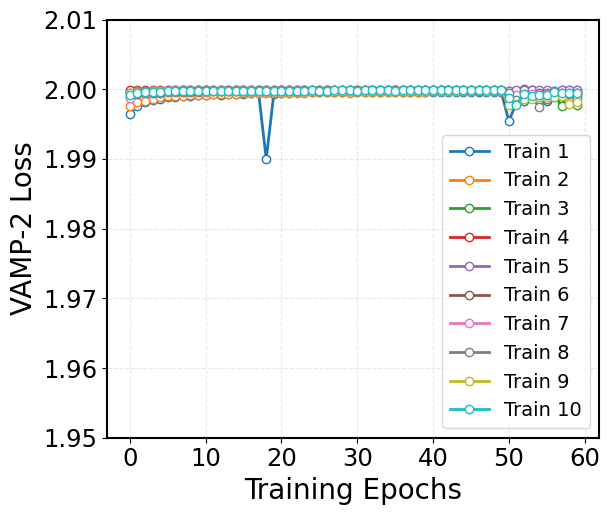

In [ ]:
val_vamp = []
for i in range(10):
    j=i+1
    file_path=f'./2states-wt/{j}/validation_vamp.npy'
    dip = np.load(file_path)
    val_vamp.append(dip)

# Define custom colors for the line and markers
line_color = 'royalblue'
marker_face = 'white'

# Plot with custom colors, line width, and markers
fig = plt.figure(figsize=(8, 6))
for idx, dip in enumerate(val_vamp):
    plt.plot(dip, linewidth=2, marker='o', markersize=6, markerfacecolor=marker_face, linestyle='-', label=f'Train {idx + 1}')

# Set the axis labels
plt.xlabel('Training Epochs', fontsize=20)
plt.ylabel('VAMP-2 Loss', fontsize=20)

plt.yticks(np.arange(1.95, 2.011, 0.01))
plt.xticks(np.arange(0, 61, 10))

# Customize tick parameters for readability
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.gca().set_box_aspect(0.85)

# Add a dashed grid to improve the readability of the plot
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='lower right', fontsize=14, markerscale=1, ncol=1)

# Adjust the layout to ensure everything fits well
plt.tight_layout()

# Display the plot
plt.show()

## Visualize the Dispersion Loss:

While the VAMP-2 loss focuses on capturing the slow dynamics, it can sometimes result in a latent space where the features collapse to similar values. To counteract this, we incorporate a **dispersion loss** that encourages diversity in the latent space. One way to formulate the dispersion loss is by ensuring that the pairwise distances between latent representations are close to a target mean distance. The dispersion loss is defined as:

$$\mathcal{L}_{dis} = \frac{1}{C} \sum_{i=1}^{C} \log \frac{1}{C-1} \sum_{j=1}^{C} \mathbf{1}_{\{j \neq i\}} e^{\frac{\mu_i^T \mu_j}{\sigma}}$$
where:
- $C$ corresponds to the number of states.
- $\mu_i$ is a unit vector representing the mean direction of all conformations (i.e., the state center) in state $i$.
- $\sigma$ is a scaling hyperparameter, which is specifically defined as 0.1.
- $\mathbf{1}_{\{j \neq i\}}$ is an indicator function that equals 1 when $j \neq i$ (i.e., excluding self-similarity) and 0 when $j = i$.

This loss penalizes deviations from the target dispersion, ensuring that the latent features remain well-separated and informative.

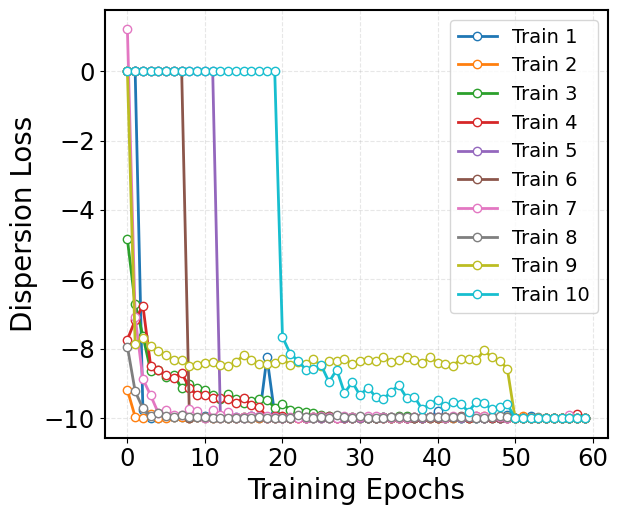

In [ ]:
# Define custom colors for the line and markers
line_color = 'royalblue'
marker_face = 'white'
#marker_edge = 'royalblue'

val_dip = []
for i in range(10):
    j=i+1
    file_path=f'./2states-wt/{j}/validation_dis.npy'
    dip = np.load(file_path)
    val_dip.append(dip)

plt.rcParams['font.size'] = 35
plt.figure(figsize=(8, 6))
for idx, dip in enumerate(val_dip):
    plt.plot(dip, linewidth=2, marker='o', markersize=6, markerfacecolor=marker_face, linestyle='-', label=f'Train {idx + 1}')

# Set the axis labels
plt.xlabel('Training Epochs', fontsize=20)
plt.ylabel('Dispersion Loss', fontsize=20)
#plt.ylim(0, 2.25)
#plt.yticks(np.arange(0, 2.1, 0.5))
plt.xticks(np.arange(0, 61, 10))

# Customize tick parameters for readability
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.gca().set_box_aspect(0.85)
plt.legend(loc='upper right', fontsize=14, markerscale=1, ncol=1)

# Add a dashed grid to improve the readability of the plot
plt.grid(alpha=0.3, linestyle='--')

# Adjust the layout to ensure everything fits well
plt.tight_layout()

# Display the plot
plt.show()

## KDE Plots of Active Site Opening Distributions for Each State:

This code plots the distribution of the selected structural feature (`MN_Carm_572_574_dist`), which measures the active site opening, across metastable states in all 10 MD trajectories.

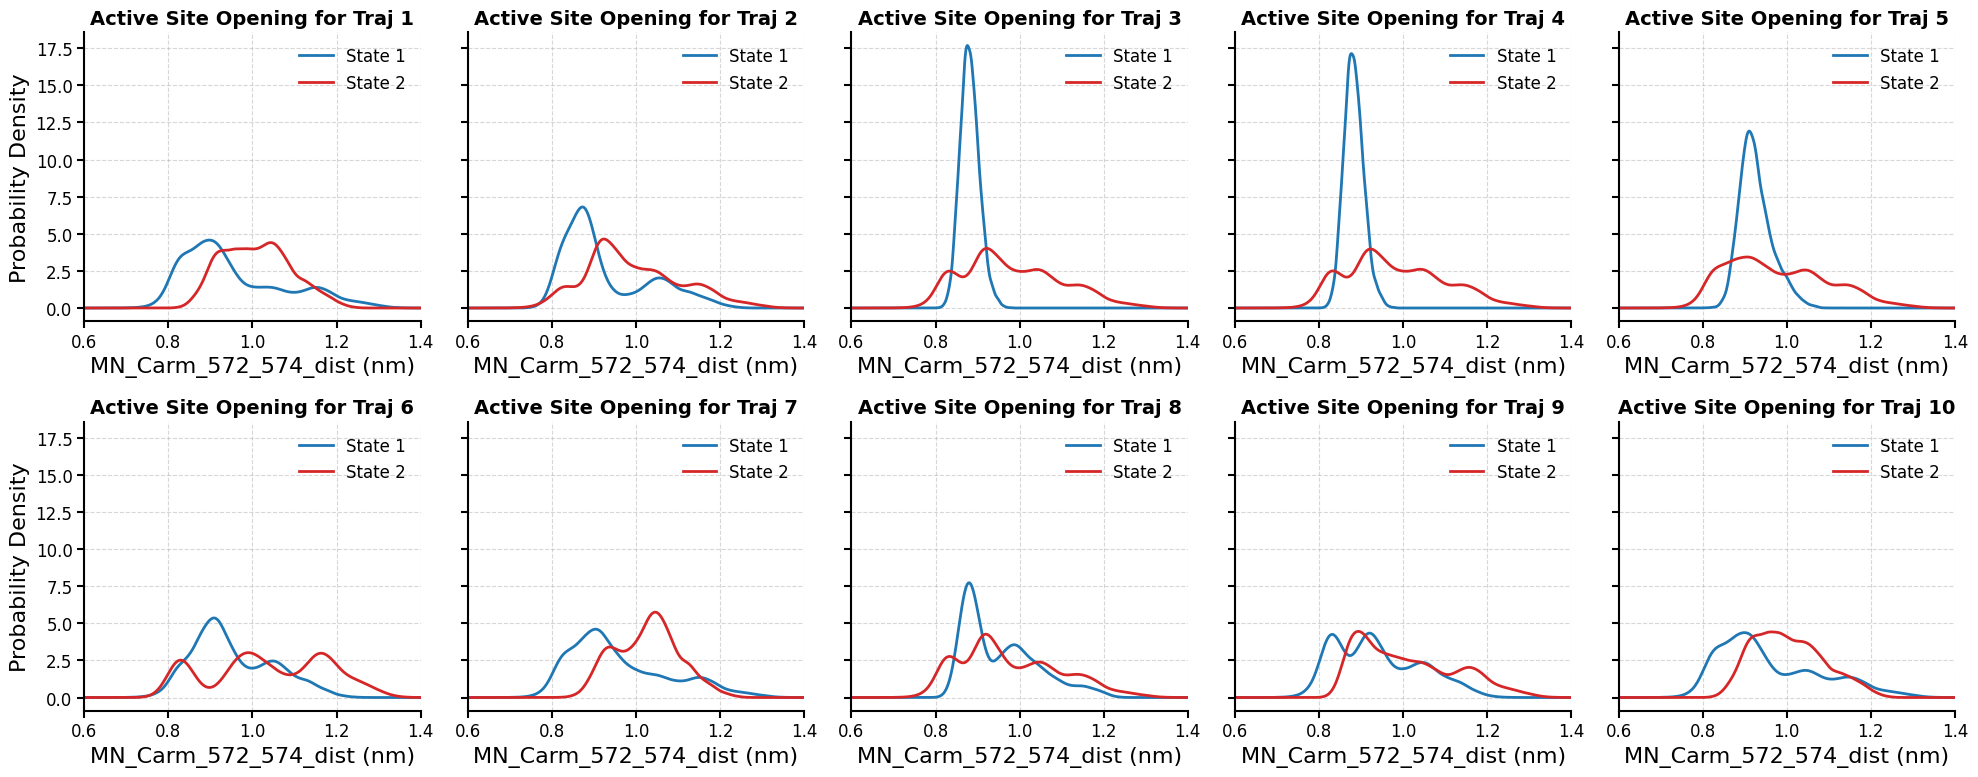

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib as mpl

# Set styles
mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'axes.linewidth': 1.5
})

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for i in range(10):
    ax = axes[i]

    # Load state assignments
    state_trajs = list(np.load(f'./2states-wt/{i+1}/metastable_states.npy', allow_pickle=True))
    states = np.concatenate(state_trajs)

    # Load features (assuming phy_coord is already defined in your environment)
    features = np.concatenate(phy_coord)

    # Separate by state
    state0 = features[states == 0]
    state1 = features[states == 1]

    # Ensure consistent ordering (state 0 always to the left)
    if np.mean(state0) > np.mean(state1):
        state0, state1 = state1, state0

    # KDE
    kde0 = gaussian_kde(state0)
    kde1 = gaussian_kde(state1)
    xgrid = np.linspace(0.6, 1.4, 500)

    # Plot KDEs with normalized weights
    ax.plot(xgrid, kde0(xgrid), color='#1f77b4', label='State 1')  # Blue
    ax.plot(xgrid, kde1(xgrid), color='#d62728', label='State 2')  # Red

    ax.set_xlim(0.6, 1.4)
    ax.set_xticks([0.6, 0.8, 1.0, 1.2, 1.4])
    ax.set_xlabel('MN_Carm_572_574_dist (nm)')
    if i % 5 == 0:
        ax.set_ylabel('Probability Density')
    ax.set_title(f'Active Site Opening for Traj {i+1}', weight='bold')
    ax.tick_params(direction='out', length=5, width=1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', frameon=False)
    ax.grid(True, linestyle='--', alpha=0.5)

# Adjust spacing
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.tight_layout()


plt.show()

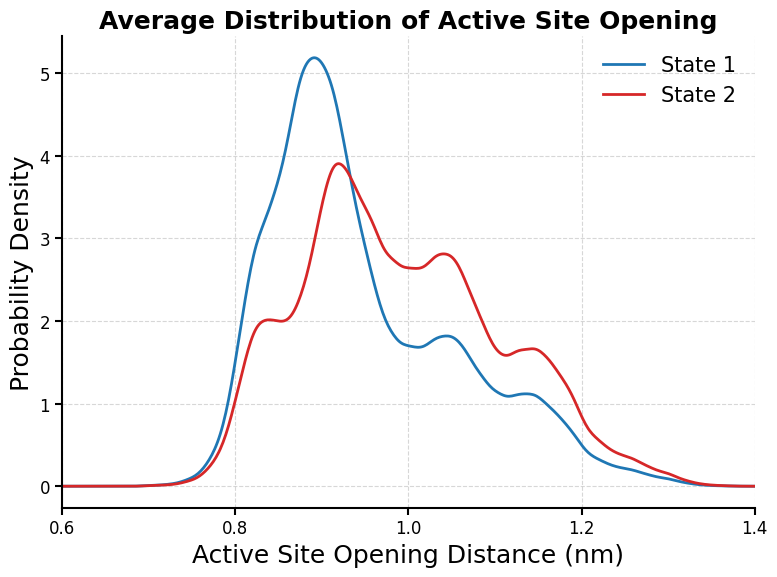

In [ ]:
# Average KDE Plot
# Collect all state0 and state1 data across all trajectories
all_state0 = []
all_state1 = []

for i in range(10):
    state_trajs = list(np.load(f'./2states-wt/{i+1}/metastable_states.npy', allow_pickle=True))
    states = np.concatenate(state_trajs)
    features = np.concatenate(phy_coord)

    state0 = features[states == 0]
    state1 = features[states == 1]

    if np.mean(state0) > np.mean(state1):
        state0, state1 = state1, state0

    all_state0.append(state0)
    all_state1.append(state1)

# Concatenate and compute average KDE
all_state0 = np.concatenate(all_state0)
all_state1 = np.concatenate(all_state1)

kde_avg0 = gaussian_kde(all_state0)
kde_avg1 = gaussian_kde(all_state1)
xgrid = np.linspace(0.6, 1.4, 500)

# Plot average KDEs
plt.figure(figsize=(8, 6))
plt.plot(xgrid, kde_avg0(xgrid), color='#1f77b4', label='State 1')
plt.plot(xgrid, kde_avg1(xgrid), color='#d62728', label='State 2')
plt.xlabel('Active Site Opening Distance (nm)', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.title('Average Distribution of Active Site Opening', fontsize=18, weight='bold')
plt.legend(frameon=False, fontsize=15)
plt.xlim(0.6, 1.4)
plt.xticks([0.6, 0.8, 1.0, 1.2, 1.4])
plt.tick_params(direction='out', length=5, width=1.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig("/Users/eshanig/Desktop/fig9B.png", dpi=300, bbox_inches='tight')
plt.show()